In [161]:
from astroquery.sdss import SDSS
import math
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from specutils.fitting import fit_generic_continuum
from specutils import Spectrum
from labellines import labelLines
import matplotlib.axes as axes
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import scipy

plt.rcParams['agg.path.chunksize'] = 120

In [163]:
eboss_fits = fits.open('eboss_dr17_summary_edapv10_cigale.fit', memmap=True)

eboss_data = eboss_fits[1].data
eboss_fits.info()
print(eboss_fits[1].columns)

Filename: eboss_dr17_summary_edapv10_cigale.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    235   1898753R x 109C   ['J', 'J', 'J', '16A', 'D', 'E', 'D', 'D', 'E', '118A', '4A', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', '9A', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', '8E', '8E', '8E', '8E', '5E', '5E', '5E', '5E', 'E', 'E', 'A', 'A', 'A', 'I', 'I', 'I']   
ColDefs(
    name = 'PLATE'; format = 'J'
    name = 'MJD'; format = 'J'
    name = 'FIBER'; format = 'J'
    name = 'PMF_STRING'; format = '16A'
    name = 'Z'; format = 'D'
    name = 'Z_ERR'; format = 'E'
    nam

In [165]:
# Remove possible +/- inf values
gals_flux = eboss_data[(eboss_data['NII_6584_FLUX_ERR']>0)]

err_range = 3

# Make sure relavent emission lines have well measured fluxes
quality_gals = gals_flux[((gals_flux['H_ALPHA_FLUX']/gals_flux['H_ALPHA_FLUX_ERR'])>err_range) &
                (((gals_flux['NII_6584_FLUX']/gals_flux['NII_6584_FLUX_ERR'])>err_range) | (gals_flux["H_GAMMA_EW"]>10)) & 
                (gals_flux['Z']<0.15)] #signal to noise ratio filter

cut_gals = quality_gals[(np.log10(quality_gals['NII_6584_FLUX']/quality_gals['H_ALPHA_FLUX'])<(-1.5))]

print(len(cut_gals))

gals_sf = cut_gals[cut_gals['SFG']==1]
gals_agn = cut_gals[cut_gals['AGN']==1]

1286


C:\Users\nihad\AppData\Local\Temp\ipykernel_20204\3052148939.py:11: RuntimeWarning: divide by zero encountered in log10
  cut_gals = quality_gals[(np.log10(quality_gals['NII_6584_FLUX']/quality_gals['H_ALPHA_FLUX'])<(-1.5))]


In [166]:
c = 3*10**5 #km/s
inf = math.inf

def h_alpha(x, amp, sig, v):
    x_0 = 6564.61 * (1+(v/c))
    wid= sig*x_0/c
    return (amp * np.exp(-(x - x_0)**2 / (2 * wid**2)))

def n_ii_1(x, amp, sig, v):
    x_0 = 6549.86 * (1+(v/c))
    wid= sig*x_0/c
    return (amp * np.exp(-(x - x_0)**2 / (2 * wid**2)))

def n_ii_2(x, amp, sig, v):
    x_0 = 6585.27 * (1+(v/c))
    wid= sig*x_0/c
    return (3*amp * np.exp(-(x - x_0)**2 / (2 * wid**2)))

def broad(x, amp, sig, v):
    x_0 = 6564.61 * (1+(v/c))
    wid= sig*x_0/c
    return (amp * np.exp(-(x - x_0)**2 / (2 * (wid)**2)))

def Gauss(x,amp1, amp2, amp3, sig1, sig2, v_n, v_b):
    return h_alpha(x, amp1, sig1, v_n) + n_ii_1(x, amp2, sig1, v_n) + n_ii_2(x, amp2, sig1, v_n) + broad(x, amp3, sig2, v_b)

0
3589-55186-368
<QuantityModel Chebyshev1D(3, c0=11.89059463, c1=0.00229644, c2=-0.00000039, c3=0.), input_units=Angstrom, return_units=Jy>
[3.49988916e+02 2.04670761e+00 2.10872096e-09 7.27268817e+01
 5.00000028e+02 8.22756654e-05 6.99491638e+05]


C:\Users\nihad\AppData\Local\Temp\ipykernel_20204\2792892981.py:20: RuntimeWarning: divide by zero encountered in divide
  uncert = 1/np.sqrt(spec_data['ivar'])


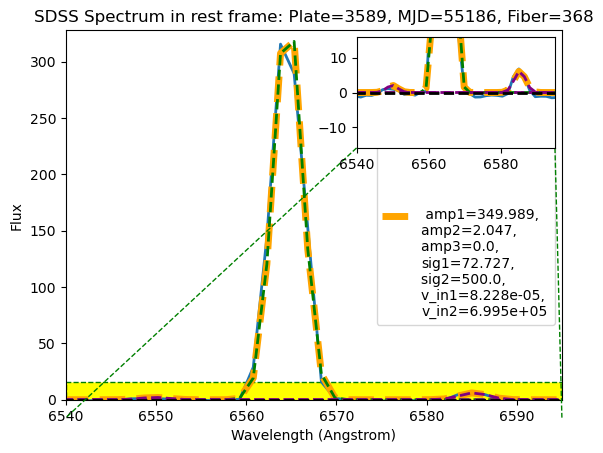

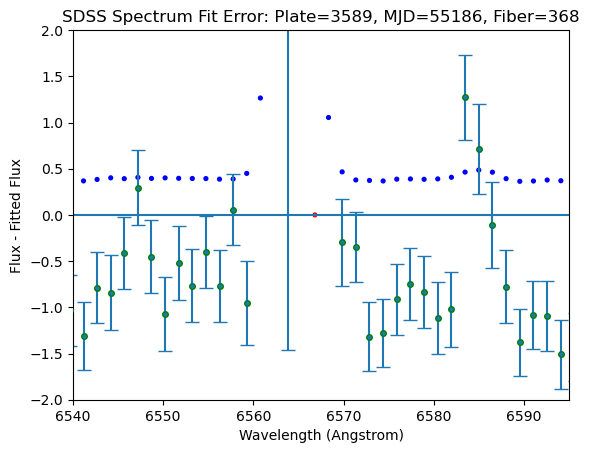

1
3589-55186-374
<QuantityModel Chebyshev1D(3, c0=9.19530926, c1=-0.00186091, c2=0.00000006, c3=-0.), input_units=Angstrom, return_units=Jy>
[7.93954590e+01 5.94258512e-01 3.52271358e-14 7.30094986e+01
 5.00000000e+02 2.74768356e-11 2.26458988e-01]


C:\Users\nihad\AppData\Local\Temp\ipykernel_20204\2792892981.py:20: RuntimeWarning: divide by zero encountered in divide
  uncert = 1/np.sqrt(spec_data['ivar'])


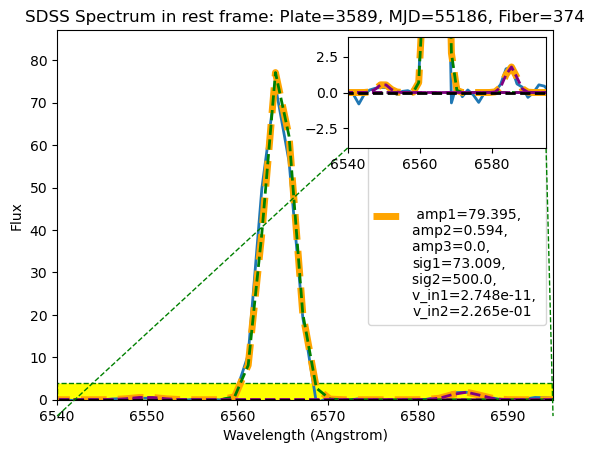

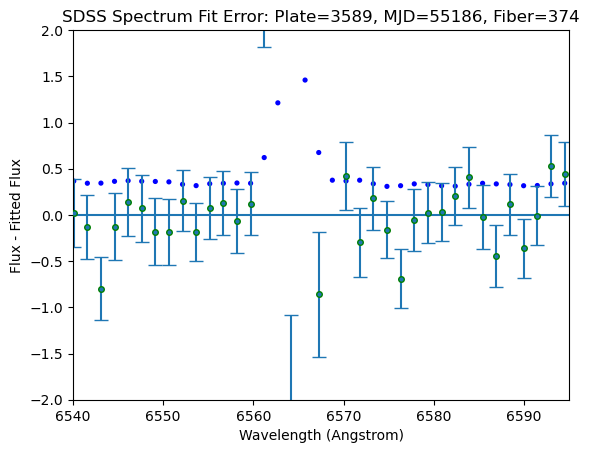

2
3590-55201-626
<QuantityModel Chebyshev1D(3, c0=2.93554653, c1=-0.00062597, c2=0.00000002, c3=-0.), input_units=Angstrom, return_units=Jy>
[1.54843992e+01 2.68543729e-07 6.91256853e-10 7.35061329e+01
 5.00000002e+02 4.05989745e-10 7.03566826e+05]


C:\Users\nihad\AppData\Local\Temp\ipykernel_20204\2792892981.py:20: RuntimeWarning: divide by zero encountered in divide
  uncert = 1/np.sqrt(spec_data['ivar'])


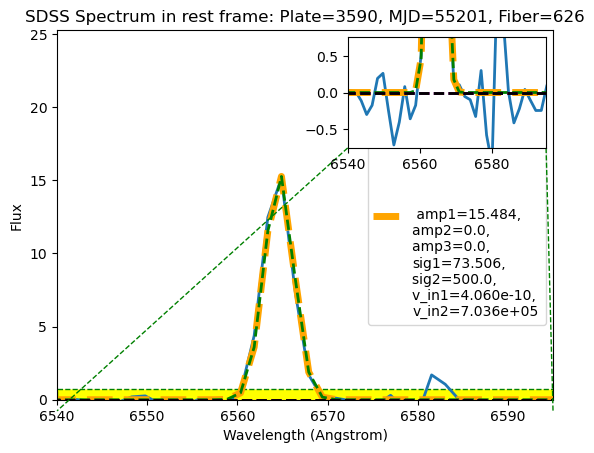

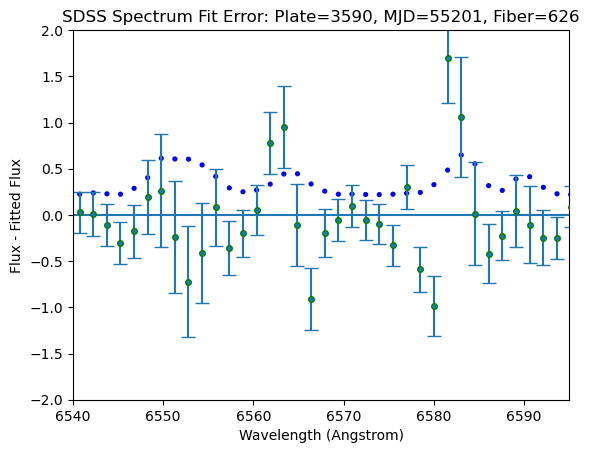

3
3615-55856-90
<QuantityModel Chebyshev1D(3, c0=1.60253805, c1=0.00107298, c2=-0.00000013, c3=0.), input_units=Angstrom, return_units=Jy>
[1.52967292e+01 9.63147833e-02 8.98973992e-08 7.51387651e+01
 5.00000200e+02 1.73449281e-05 6.80952399e+05]


C:\Users\nihad\AppData\Local\Temp\ipykernel_20204\2792892981.py:20: RuntimeWarning: divide by zero encountered in divide
  uncert = 1/np.sqrt(spec_data['ivar'])


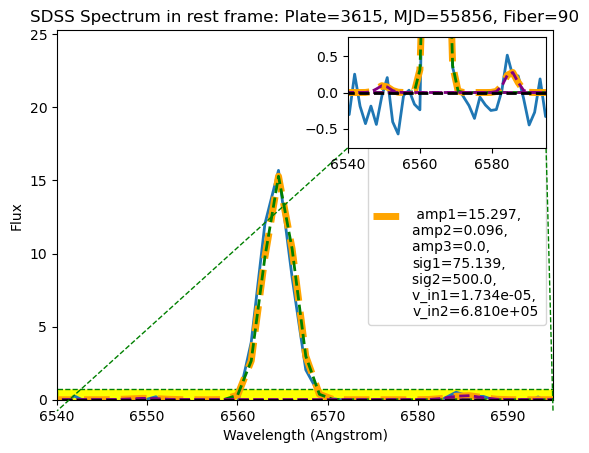

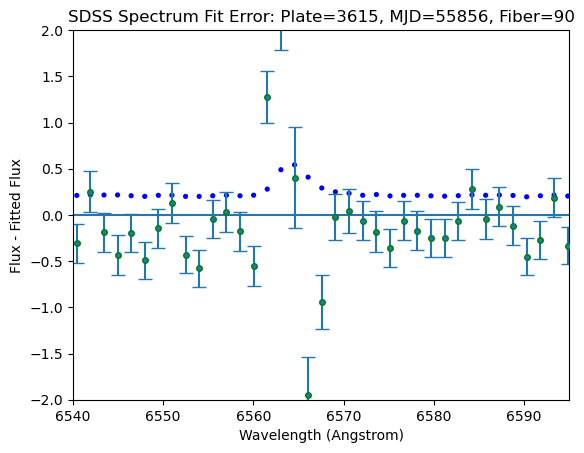

4
3615-56544-100
<QuantityModel Chebyshev1D(3, c0=1.07421729, c1=0.00166383, c2=-0.00000019, c3=0.), input_units=Angstrom, return_units=Jy>
[1.62619217e+01 6.67777234e-02 3.12575680e-09 7.92198187e+01
 5.00000003e+02 3.24100496e-08 7.03048598e+05]


C:\Users\nihad\AppData\Local\Temp\ipykernel_20204\2792892981.py:20: RuntimeWarning: divide by zero encountered in divide
  uncert = 1/np.sqrt(spec_data['ivar'])


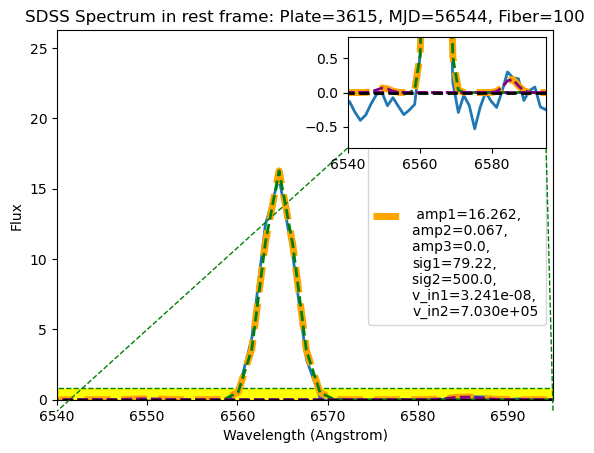

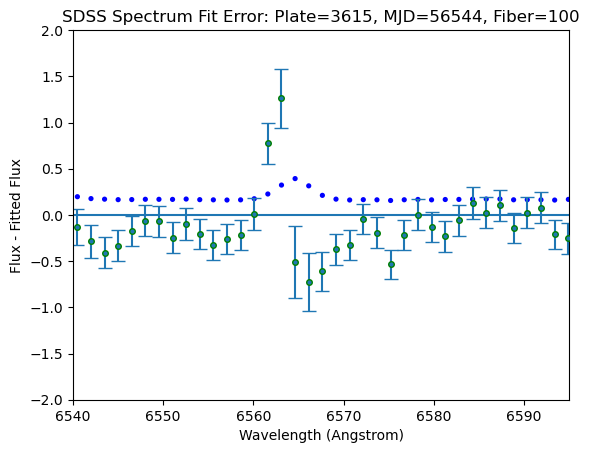

5
3647-55241-46
<QuantityModel Chebyshev1D(3, c0=1.39065481, c1=0.00095081, c2=-0.00000009, c3=0.), input_units=Angstrom, return_units=Jy>
[2.34089641e+01 1.08486636e-01 3.05725013e-10 6.93502959e+01
 5.00000002e+02 1.79650380e-11 7.77607893e+05]


C:\Users\nihad\AppData\Local\Temp\ipykernel_20204\2792892981.py:20: RuntimeWarning: divide by zero encountered in divide
  uncert = 1/np.sqrt(spec_data['ivar'])


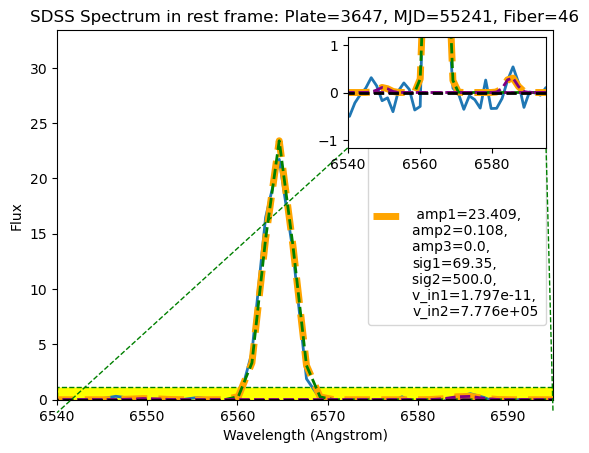

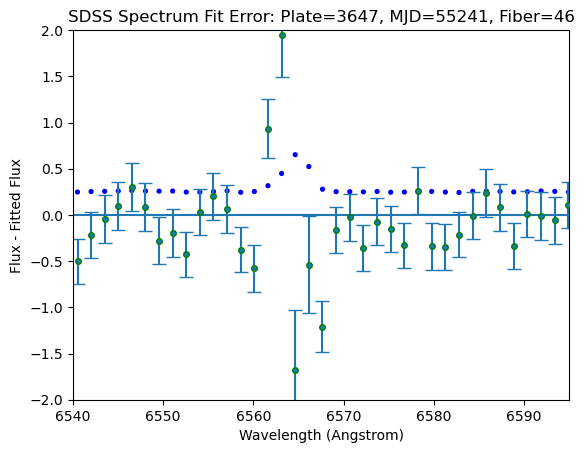

6
3647-56568-42
<QuantityModel Chebyshev1D(3, c0=-7.79686682, c1=0.0072587, c2=-0.00000064, c3=0.), input_units=Angstrom, return_units=Jy>
[1.09732680e+02 8.77492932e-01 4.88767307e-02 8.91072437e+01
 5.00000811e+02 6.04608721e-18 3.86807111e+04]


C:\Users\nihad\AppData\Local\Temp\ipykernel_20204\2792892981.py:20: RuntimeWarning: divide by zero encountered in divide
  uncert = 1/np.sqrt(spec_data['ivar'])


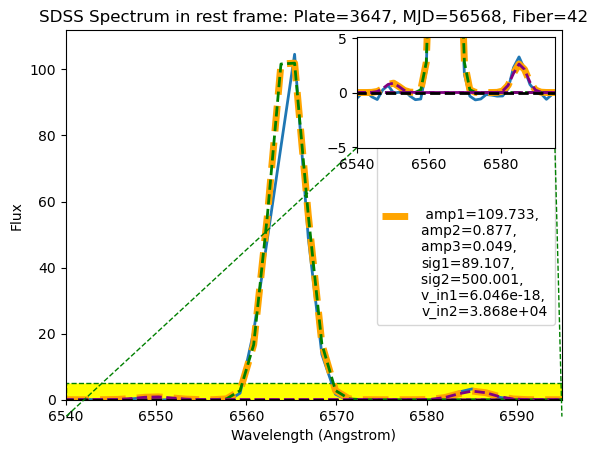

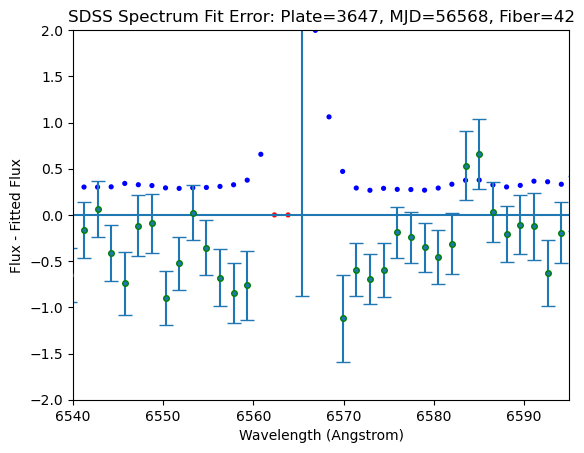

7
3650-55244-340
<QuantityModel Chebyshev1D(3, c0=2.52734216, c1=0.00091024, c2=-0.00000012, c3=0.), input_units=Angstrom, return_units=Jy>
[9.02442142e+01 1.69784467e-01 5.47054264e-12 6.92324867e+01
 5.00000000e+02 4.12282114e-01 7.07112084e+05]


C:\Users\nihad\AppData\Local\Temp\ipykernel_20204\2792892981.py:20: RuntimeWarning: divide by zero encountered in divide
  uncert = 1/np.sqrt(spec_data['ivar'])


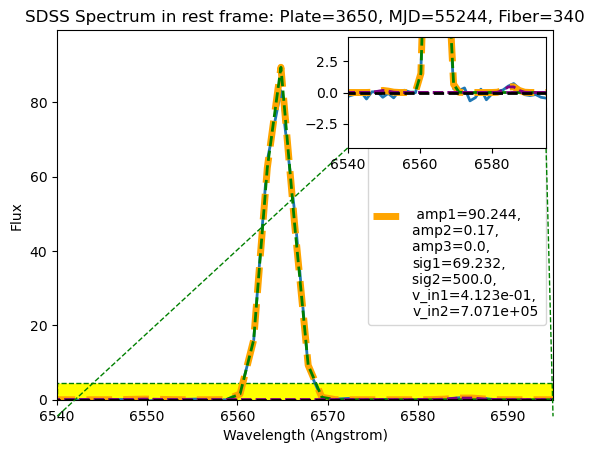

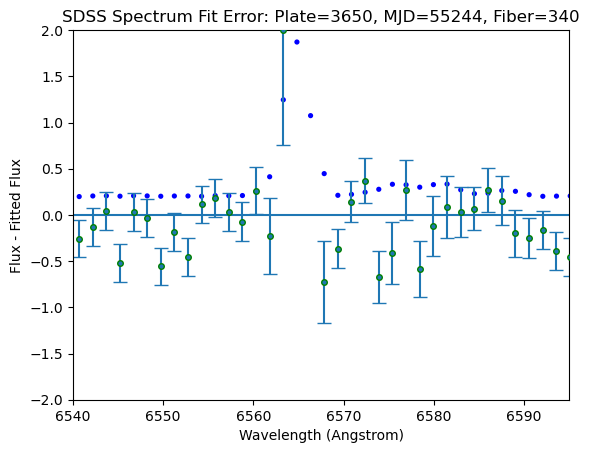

8
3657-55244-4
<QuantityModel Chebyshev1D(3, c0=-4.22265531, c1=0.00267596, c2=-0.00000023, c3=0.), input_units=Angstrom, return_units=Jy>
[2.00288691e+01 1.48313083e-01 1.04625031e-08 6.59824945e+01
 5.00000024e+02 4.56448899e-10 7.48929710e+05]


C:\Users\nihad\AppData\Local\Temp\ipykernel_20204\2792892981.py:20: RuntimeWarning: divide by zero encountered in divide
  uncert = 1/np.sqrt(spec_data['ivar'])


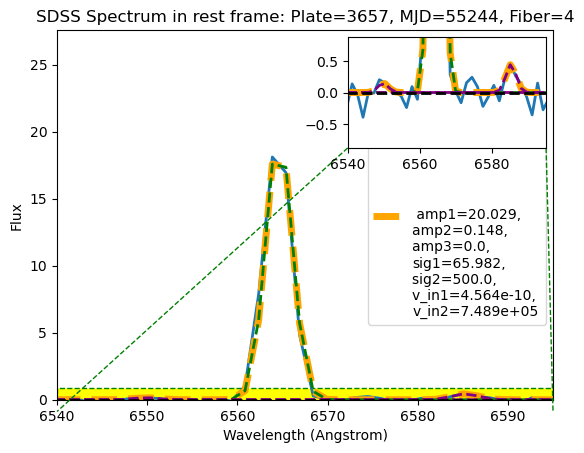

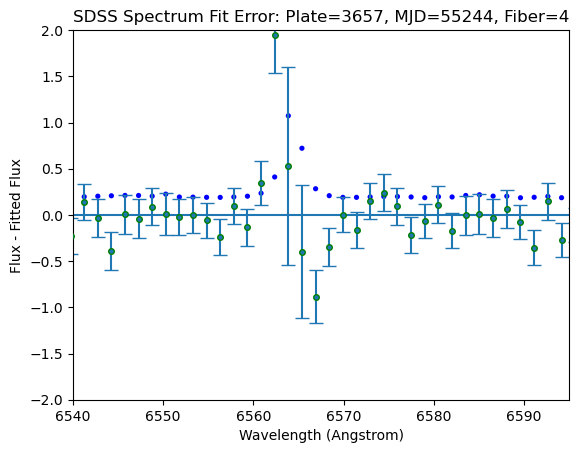

9
3658-55205-474
<QuantityModel Chebyshev1D(3, c0=6.33984297, c1=-0.00235204, c2=0.00000015, c3=-0.), input_units=Angstrom, return_units=Jy>
[1.27576287e+01 9.82347040e-02 6.33955149e-02 6.96605721e+01
 7.40949940e+02 7.33490316e-41 3.55010938e+04]


C:\Users\nihad\AppData\Local\Temp\ipykernel_20204\2792892981.py:20: RuntimeWarning: divide by zero encountered in divide
  uncert = 1/np.sqrt(spec_data['ivar'])


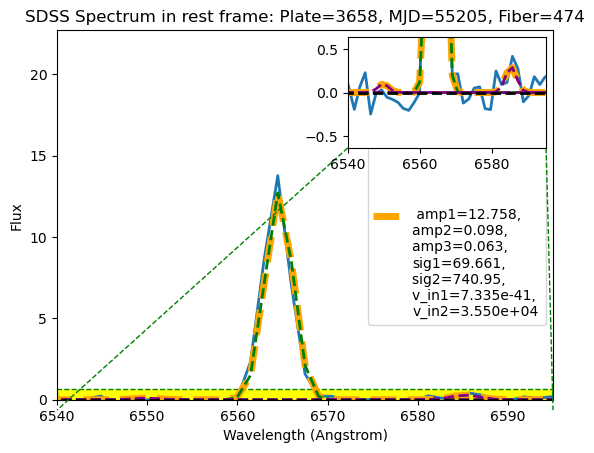

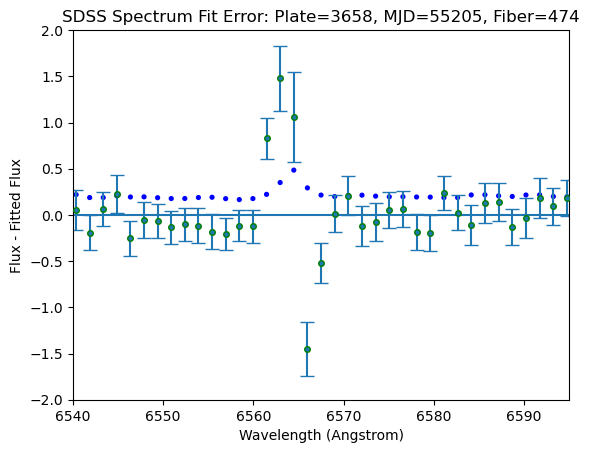

In [327]:
xvals = [6564.61, 5008.240, 4960.295, 4862.68, 4102.89, 4341.68 ]
label = ['Hα', 'OIII', 'OIII', 'Hβ', 'HΔ', 'Hγ']
for i in range(10):
    print(i)
    gal = cut_gals[i]
 
    plate = gal["PLATE"]
    mjd = gal["MJD"]
    fiber = gal["FIBER"]
    print(str(gal["PLATE"]) + "-" + str(gal["MJD"])+ "-"+ str(gal["FIBER"]))
    sp = SDSS.get_spectra(plate=plate, mjd=mjd, fiberID=fiber)
    if sp:
        spec_hdu = sp[0]
        spec_data = spec_hdu[1].data
        z = spec_hdu[2].data["z"]

        loglam = spec_data['loglam']
        flux = spec_data['flux']
        wavelength = 10**loglam
        uncert = 1/np.sqrt(spec_data['ivar'])

        spec1d = Spectrum(spectral_axis=wavelength/(1+z)*u.AA, flux=flux*u.Jy)
        continuum=fit_generic_continuum(spec1d)
        print(continuum)
        fit_cont = continuum(wavelength/(1+z)*u.AA)

        parameters, covariance = curve_fit(Gauss, wavelength/(1+z), flux*u.Jy-fit_cont,sigma = uncert,  method = "trf", p0=[150,20,2, 50, 1000, 50, 50], 
                                           bounds=([0,0,0,50,500, 0, 0],[inf, inf,5,500, 5000, inf, inf]))
        print(parameters)
        A, B, C, D, E, F, G = parameters
        fit = Gauss(wavelength/(1+z), A, B, C, D, E, F, G)
        ymax = np.max(fit)

        fig, ax = plt.subplots()
        plt.plot(wavelength/(1+z), flux*u.Jy-fit_cont, linewidth=2)
        plt.plot(wavelength/(1+z), fit, '--', color = 'orange',linewidth=5, label=f"\n \n \n \n \n \n amp1={round(A,3)}, \namp2={round(B,3)}, \namp3={round(C,3)}, \nsig1={round(D,3)},\nsig2={round(E,3)}, \nv_in1={F:.3e}, \nv_in2={G:.3e}")
        plt.plot(wavelength/(1+z), h_alpha(wavelength/(1+z), A, D, F), '--',color = 'green',linewidth=2)
        plt.plot(wavelength/(1+z), n_ii_1(wavelength/(1+z), B, D, F), '--',color = 'purple',linewidth=2)
        plt.plot(wavelength/(1+z), n_ii_2(wavelength/(1+z), B, D, F), '--',color = 'purple',linewidth=2)
        plt.plot(wavelength/(1+z), broad(wavelength/(1+z), C, E, G), '--',color = 'black',linewidth=2)
        plt.xlim(6540, 6595)
        plt.ylim(0,ymax+10)
        plt.xlabel("Wavelength (Angstrom)")
        plt.ylabel("Flux")
        plt.title(f"SDSS Spectrum in rest frame: Plate={plate}, MJD={mjd}, Fiber={fiber}") 
        plt.legend(loc='center right')

        #inset plot
        inset = inset_axes(ax, width='40%', height='30%', loc='upper right',)
        inset.plot(wavelength/(1+z), flux*u.Jy-fit_cont, linewidth=2, label='Data')
        inset.plot(wavelength/(1+z), fit, '--', color = 'orange',linewidth=5)
        inset.plot(wavelength/(1+z), h_alpha(wavelength/(1+z), A, D, F), '--',color = 'green',linewidth=2)
        inset.plot(wavelength/(1+z), n_ii_1(wavelength/(1+z), B, D, F), '--',color = 'purple',linewidth=2)
        inset.plot(wavelength/(1+z), n_ii_2(wavelength/(1+z), B, D, F), '--',color = 'purple',linewidth=2)
        inset.plot(wavelength/(1+z), broad(wavelength/(1+z), C, E, G), '--',color = 'black',linewidth=2)
        inset.set_xlim(6540, 6595)
        inset.set_ylim(-ymax/20, ymax/20)
        mark_inset(ax, inset, loc1=3, loc2=4, fc='yellow', ec='g', ls='--')

        plt.savefig(str(gal["PLATE"]) + "-" + str(gal["MJD"])+ "-"+ str(gal["FIBER"])+"_Gaussian.jpeg")
        plt.show()

        err = flux-fit_cont/u.Jy-fit
        infty = []
        color = []
        uncert = [(1/np.sqrt(item)) if (item != 0) else 0 for item in spec_data['ivar']]
        color = ['blue' if (item != 0) else 'red' for item in spec_data['ivar']]
        plt.errorbar(wavelength/(1+z), err, yerr = uncert, fmt='o',markersize=4, zorder=2.5, capsize=5, markeredgecolor="green", label='Data')
        plt.scatter(wavelength/(1+z), uncert, color = color, linewidth=2, s = 3, label='Data')
        plt.axhline(y = 0)
        plt.xlabel("Wavelength (Angstrom)")
        plt.ylabel("Flux - Fitted Flux")
        plt.title(f"SDSS Spectrum Fit Error: Plate={plate}, MJD={mjd}, Fiber={fiber}")
        plt.xlim(6540, 6595)
        plt.ylim(-2, 2)
        plt.savefig(str(gal["PLATE"]) + "-" + str(gal["MJD"])+ "-"+ str(gal["FIBER"])+"_Gaussian_err.jpeg")

        plt.show()